In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import nltk
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [4]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [5]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [7]:
df_train['text'] = df_train['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')

df_train['text']=df_train['text'].apply(denoise_text)
df_test['text']=df_test['text'].apply(denoise_text)

<ipython-input-4-87fc072d711e>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [27]:
# Generate dummy data
X_train = df_train['text'] # List of text data
y_train = df_train['sentiment']

X_test = df_test['text'] # List of text data
y_test= df_test['sentiment']

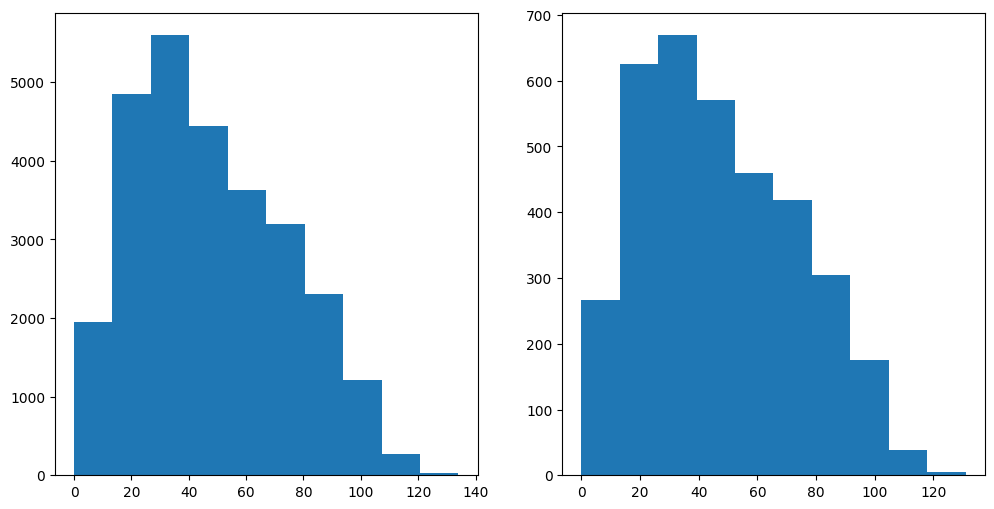

In [9]:
# Plotting the size of the sequences

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [10]:
import os
import gensim.downloader as api
from gensim.models import KeyedVectors

# Download and load the pre-trained word2vec model
word2vec_model_name = "word2vec-google-news-300"

# Check if the model is available in gensim API
if not api.info(name=word2vec_model_name):
    print(f"Word2Vec model '{word2vec_model_name}' is not available in the gensim API.")
else:
    # Load the pre-trained model
    print("Loading pre-trained word2vec model...")
    word2vec_model = api.load(word2vec_model_name)
    print("Model loaded successfully.")

Loading pre-trained word2vec model...
Model loaded successfully.


In [11]:
import numpy as np

# Define a function to tokenize text and obtain word vectors
def text_to_word_vectors(text, word2vec_model):
    # Tokenize the text into words
    tokens = text.split()
    word_vectors = []
    for token in tokens:
        # Check if the word is in the vocabulary of the word2vec model
        if token in word2vec_model:
            # Obtain the word vector for the word
            word_vector = word2vec_model[token]
            word_vectors.append(word_vector)
            
    # Aggregate word vectors to represent the text as a single vector
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)  # Take the mean of word vectors
    else:
        # If no word vectors found for the text, return a zero vector
        text_vector = np.zeros(word2vec_model.vector_size)
    return text_vector

# Iterate through each text in the 'text' column of df_train and obtain word vectors
train_text_vectors = []
test_text_vectors=[]
for text in df_train['text']:
    text_vector = text_to_word_vectors(text, word2vec_model)
    train_text_vectors.append(text_vector)

for text in df_test['text']:
    text_vector = text_to_word_vectors(text, word2vec_model)
    test_text_vectors.append(text_vector)

# Convert the list of text vectors to a numpy array
train_text_vectors_array = np.array(train_text_vectors)
test_text_vectors_array = np.array(test_text_vectors)

In [12]:
train_text_vectors_array.shape

(27481, 300)

In [14]:
# Initialize an empty set to store unique words
unique_words = set()

for text in df_train['text']:
    # Tokenize the text into words
    words = text.split()
    # Add unique words to the set
    unique_words.update(words)

# Vocabulary size is the number of unique words
vocab_size = len(unique_words)

print("Vocabulary size:", vocab_size)

embedding_dim = 300
num_filters = 128
filter_sizes = [3, 4, 5]
dropout_rate = 0.5
num_classes = 3

vocab_size = train_text_vectors_array.shape[0]

Vocabulary size: 50662


In [21]:
embedding_dim = 300
num_filters = 128
filter_sizes = [3, 4, 5]
dropout_rate = 0.5
num_classes = 3
num_heads = 6

import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs)  
        query = self.separate_heads(query, batch_size)  
        key = self.separate_heads(key, batch_size)  
        value = self.separate_heads(value, batch_size) 
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

# Define the model architecture
max_seq_length = train_text_vectors_array.shape[1]  # Adjusted to match the length of word vectors
input_layer = tf.keras.layers.Input(shape=(max_seq_length,))
multi_head_attention = MultiHeadSelfAttention(embed_dim=embedding_dim, num_heads=num_heads)(input_layer)
cnn_layers = []

for filter_size in filter_sizes:
    conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu', padding='same')(multi_head_attention)
    pool_layer = GlobalMaxPooling1D()(conv_layer)
    cnn_layers.append(pool_layer)
    
cnn_output = Concatenate()(cnn_layers)
dropout_layer = Dropout(rate=dropout_rate)(cnn_output)
norm_layer = LayerNormalization()(dropout_layer)
output_layer = Dense(num_classes, activation='softmax')(norm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 multi_head_self_attention_  (None, None, 300)            361200    ['input_4[0][0]']             
 3 (MultiHeadSelfAttention)                                                                       
                                                                                                  
 conv1d_6 (Conv1D)           (None, None, 128)            115328    ['multi_head_self_attention_3[
                                                                    0][0]']                       
                                                                                            

In [17]:
le = LabelEncoder()
num_classes=3

y_train = le.fit_transform(y_train)
# y_test = le.transform(y_val)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
# y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

In [23]:
history= model.fit(train_text_vectors_array, y_train_one_hot, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
344/344 [==============================] - 6s 11ms/step - loss: 0.7069 - accuracy: 0.6909 - auc_2: 0.8629 - val_loss: 0.9486 - val_accuracy: 0.6445 - val_auc_2: 0.8079
Epoch 2/50
344/344 [==============================] - 3s 8ms/step - loss: 0.7041 - accuracy: 0.6945 - auc_2: 0.8643 - val_loss: 0.9583 - val_accuracy: 0.6383 - val_auc_2: 0.8080
Epoch 3/50
344/344 [==============================] - 3s 7ms/step - loss: 0.7005 - accuracy: 0.6930 - auc_2: 0.8655 - val_loss: 0.9704 - val_accuracy: 0.6378 - val_auc_2: 0.8077
Epoch 4/50
344/344 [==============================] - 3s 10ms/step - loss: 0.6983 - accuracy: 0.6979 - auc_2: 0.8660 - val_loss: 0.9835 - val_accuracy: 0.6316 - val_auc_2: 0.8015
Epoch 5/50
344/344 [==============================] - 4s 11ms/step - loss: 0.6917 - accuracy: 0.6962 - auc_2: 0.8686 - val_loss: 0.9744 - val_accuracy: 0.6314 - val_auc_2: 0.8022
Epoch 6/50
344/344 [==============================] - 3s 8ms/step - loss: 0.6945 - accuracy: 0.6956 - auc_2

In [24]:
# Test the model
y_pred = np.argmax(model.predict(test_text_vectors_array), axis=-1)

111/111 [==============================] - 1s 4ms/step


In [28]:
y_test = le.transform(y_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict(test_text_vectors_array), multi_class='ovr')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC Score:", roc_auc)

111/111 [==============================] - 0s 3ms/step
Accuracy: 0.6324278438030561
Precision: 0.6374684531379619
Recall: 0.6324278438030561
F1 Score: 0.6333503914331996
Confusion Matrix:
 [[601 332  68]
 [281 934 215]
 [ 69 334 700]]
ROC AUC Score: 0.7928899763126637


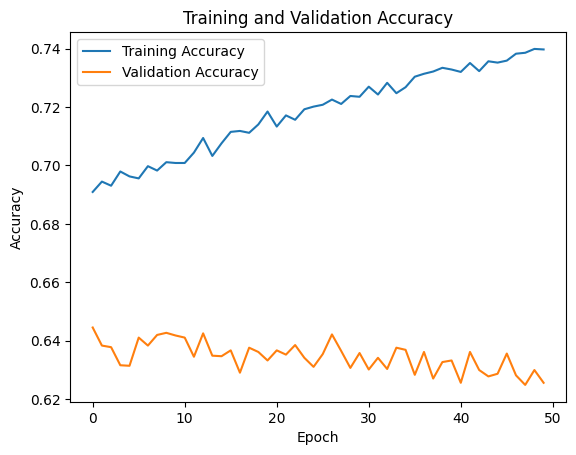

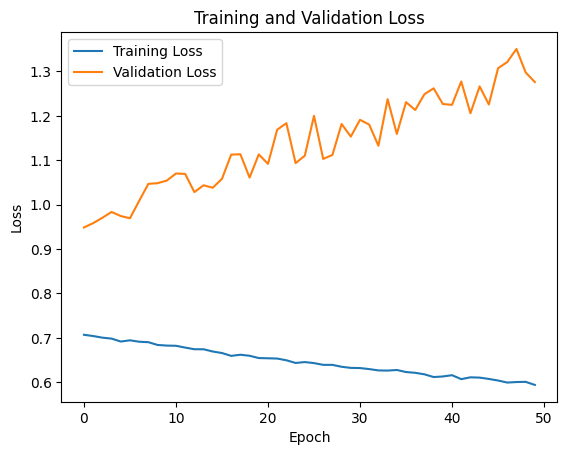

In [29]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


111/111 [==============================] - 1s 5ms/step


<Axes: >

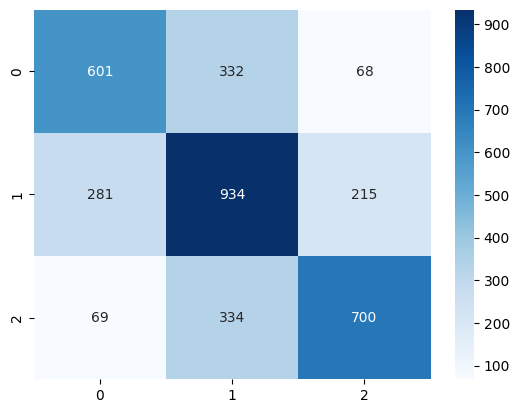

In [31]:
# Evaluate the model
y_pred = np.argmax(model.predict(test_text_vectors_array), axis=-1)

# Metrics and Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

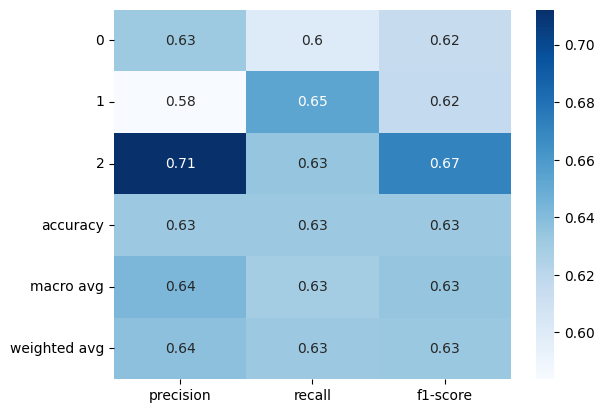

In [32]:
clf_report=classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,  cmap="Blues")
plt.show()

In [38]:
# Convert predicted labels to a DataFrame
df_results = pd.DataFrame({'Text': X_test,
                           'True_Label': le.inverse_transform(np.argmax(y_test, axis=1)),
                           'Predicted_Label': le.inverse_transform(y_pred)})

# Print the DataFrame
df_results

,Text,True_Label,Predicted_Label
0,Last session day,neutral,neutral
1,Shanghai also really exciting (precisely -- sk...,positive,positive
2,"Recession hit Veronique Branquinho, quit compa...",negative,negative
3,happy bday!,positive,positive
4,like it!!,positive,neutral
...,...,...,...
3529,"3 am, im tired can`t sleep try",negative,negative
3530,alone old house again. Thanks net keeps alive ...,positive,positive
3531,know mean. little dog sinking depression... wa...,negative,neutral
3532,_sutra next youtube video gonna about? love vi...,positive,positive


111/111 [==============================] - 1s 5ms/step
Overall ROC-AUC Score: 0.7928899763126637


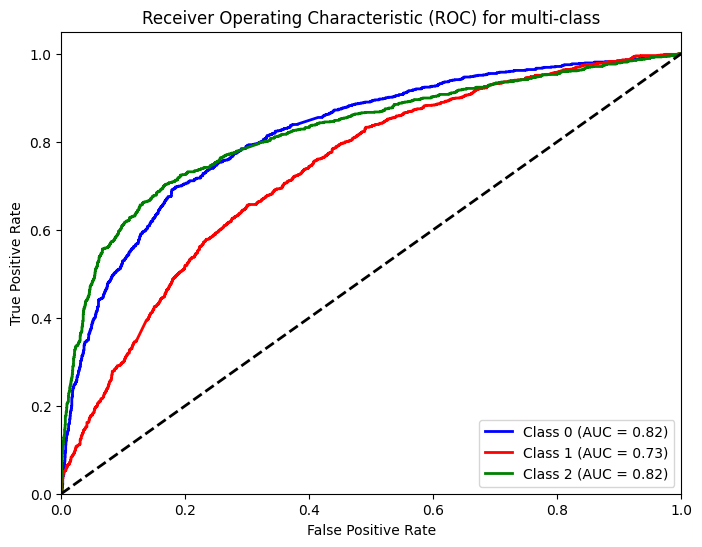

In [33]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Convert y_test to one-hot encoded format if it's not already
if len(y_test.shape) == 1:
    label_binarizer = LabelBinarizer()
    y_test = label_binarizer.fit_transform(y_test)

# Calculate the ROC AUC Score
y_prob = model.predict(test_text_vectors_array)
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"Overall ROC-AUC Score: {roc_auc_ovr}")

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for multi-class')
plt.legend(loc="lower right")
plt.show()

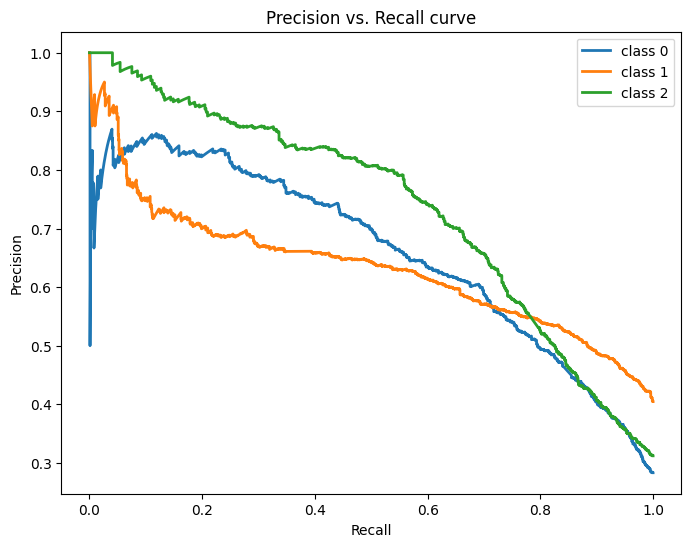

In [34]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


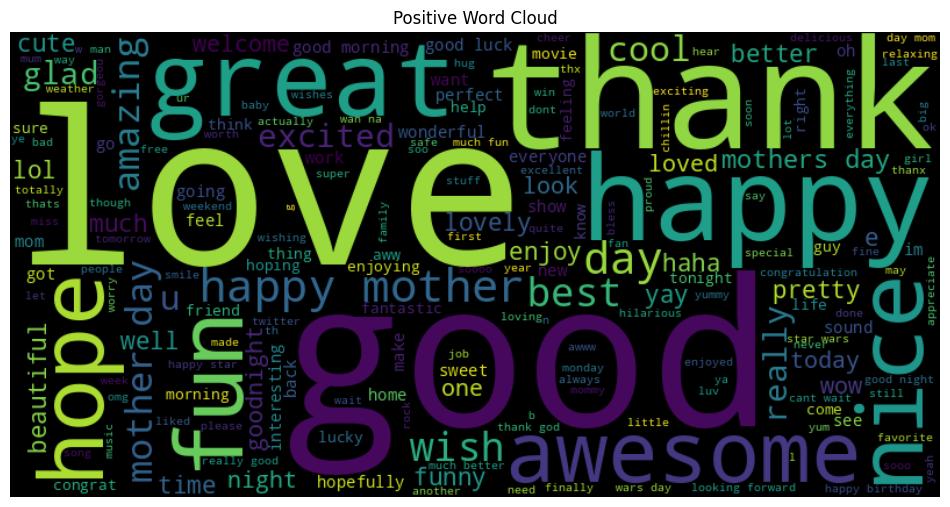

In [42]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
positive_texts = df_train[df_train['sentiment'] == 'positive']['selected_text']
negative_texts = df_train[df_train['sentiment'] == 'negative']['selected_text']
neutral_texts = df_train[df_train['sentiment'] == 'neutral']['selected_text']

# Tokenize and extract words for each sentiment category
positive_words = [word.lower() for text in positive_texts for word in word_tokenize(str(text))]
negative_words = [word.lower() for text in negative_texts for word in word_tokenize(str(text))]
neutral_words = [word.lower() for text in neutral_texts for word in word_tokenize(str(text))]

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
positive_words = [word for word in positive_words if word not in stop_words]
negative_words = [word for word in negative_words if word not in stop_words]
neutral_words = [word for word in neutral_words if word not in stop_words]

def plot_word_cloud(words, title):
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(words))
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_word_cloud(positive_words, 'Positive Word Cloud')

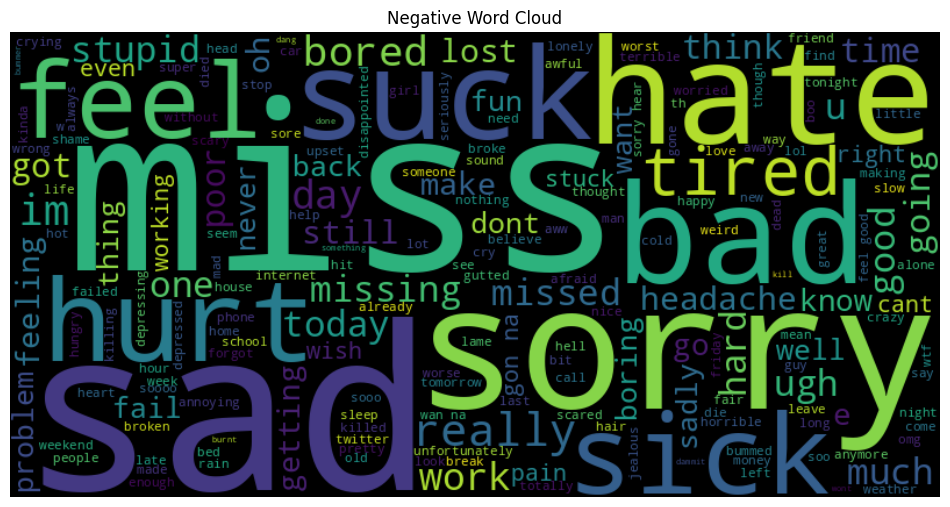

In [ ]:
plot_word_cloud(negative_words, 'Negative Word Cloud')

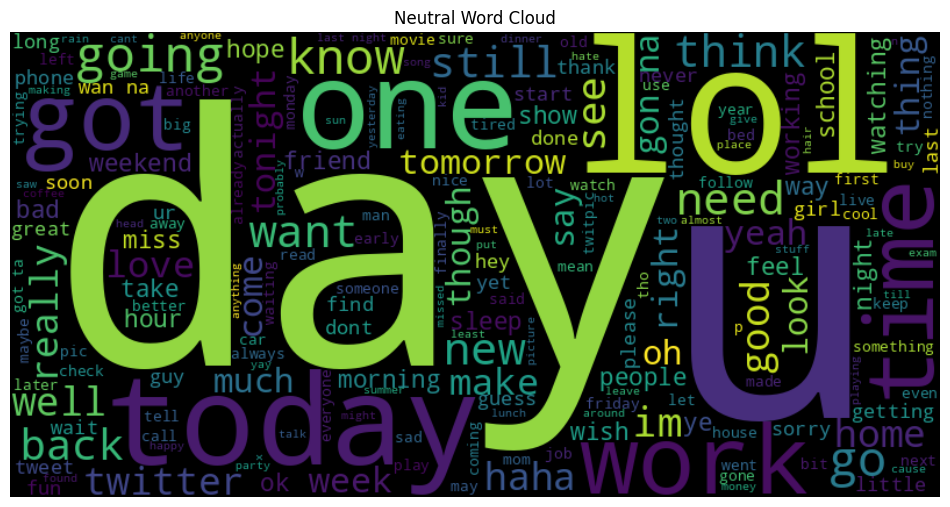

In [ ]:
plot_word_cloud(neutral_words, 'Neutral Word Cloud')

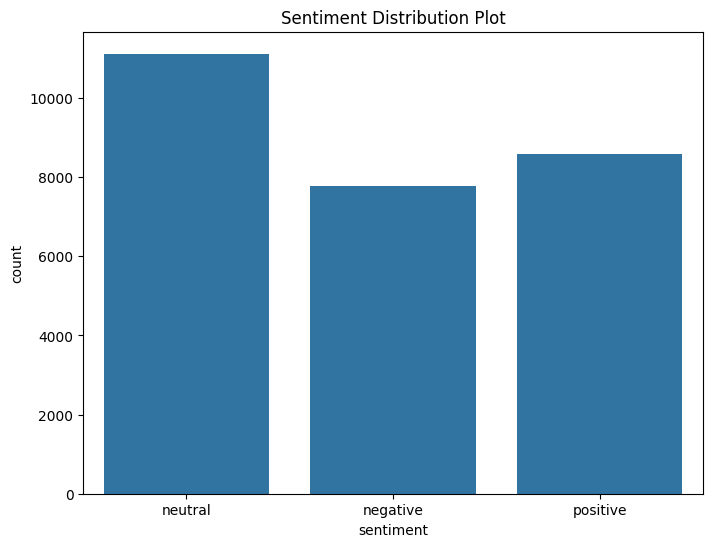

In [ ]:
# Sentiment Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_train)
plt.title('Sentiment Distribution Plot')
plt.show()

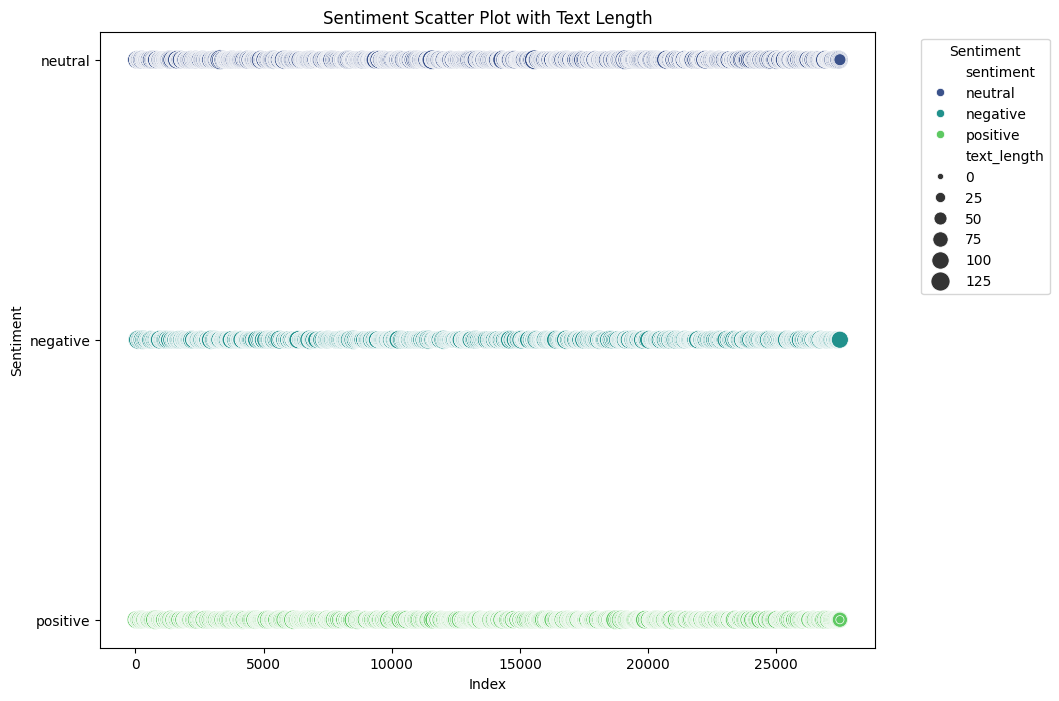

In [40]:
plt.figure(figsize=(10, 8))
df_train['text_length'] = df_train['text'].apply(len)

sns.scatterplot(x=df_train.index, y='sentiment', size='text_length', data=df_train, hue='sentiment', sizes=(20, 200), palette='viridis')
plt.title('Sentiment Scatter Plot with Text Length')
plt.xlabel('Index')
plt.ylabel('Sentiment')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()